# An Appreciation of Cover's Universal Portfolio in Python

John Mount

Win-Vector LLC

2-23-2022



I'd like to discuss a fantastic theoretical investment thought tool, the [Cover universal portfolio](https://web.mit.edu/6.454/www/www_fall_2001/shaas/universal_portfolios.pdf). Any comments can be left [here](https://win-vector.com/2022/02/23/an-appreciation-of-covers-universal-portfolio-in-python/).

The Cover universal portfolio is re-balancing scheme that attempts to build a changing portfolio of investments that, with high probability, outperforms *all* of its constituent investments. It is an amazing though experiment.

There are practical concerns in directly using such a scheme including:

  * Accepting maximizing expected log-return as an objective.
  * Not modeling trade costs.
  * Not modeling variance or risk.
  * Not modeling forgetting rate or time scales.

However, even given these concerns the idea is brilliant: simulate many portfolio managers and re-allocate funds to the winners. These winning sub-managers not only have their own profits to re-invest, but also funds confiscated from alternate strategies.

Another way to frame the idea is: we follow simulated dollars. In this scheme most of our simulated dollars end up with the better simulated strategies. So following where the dollars end up marks these strategies.

I can't hope to explain this as clearly as [Cover
 himself](https://web.mit.edu/6.454/www/www_fall_2001/shaas/universal_portfolios.pdf). However, I can translate a bit of it into Python- which many programmers find easy to read.

I'll try to use a few terms consistently:

  * **Underlying instrument** the individual items we are investing in.
  * **Investment**, **allocation**, or **portfolio** the distribution of what fraction of wealth is invested in each underlying instrument.

The goal is to at each time step, using only information from the past, estimate a good allocation of our actual holdings into underlying instruments. We do this by rating the performance of many simulated allocations.

In [1]:
# import packages
from typing import Dict, List, Optional, Tuple
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# define our initial simulation of a population of portfolios
# it is a map from a vector saying what fraction of investment is
# in each underlying instrument to current simulated value of the
# investment. we start with all portfolios with an equal initial
# simulated investment.
def initial_portfolios(*, dim: int, n: int) -> Dict[np.ndarray, float]:
    """
    Build initial portfolios

    :param dim: number of instruments
    :param n: number of portfolios per dimension/instrument
    :return: map of portfolios defs to current values
    """
    portfolios = list(set([
        tuple(np.array(v) / max(1, np.sum(v)))
        for v in product(range(n), repeat=dim)
        if np.sum(v) > 0
    ]))
    portfolios.sort()
    return {b: 1/len(portfolios) for b in portfolios}

In [3]:
# evolve the portfolios one time step forward.
# this is a function of x, the most recent relative
# returns on each instrument.
# the forgive rate is not part of the standard Cover
# derivation, it simulates pulling some money from all
# simulated portfolios and re-distributing it.
# it causes the simulation to forget the past faster.
def evolve_portfolios(
        portfolios: Dict[np.ndarray, float],
        x: np.ndarray,
        forgive_rate: float = 0.0,
) -> Dict[np.ndarray, float]:
    """
    Evolve portfolio estimates one step forward in time.

    :param portfolios: current portfolios
    :param x: most recent reported relative returns
    :param forgive_rate: forgiving or forgetful re-allocation, this fraction of wealth is redistributed instead of being invested.
    :return: values of portfolios one step forward
    """
    total_value = np.sum([s_k for s_k in portfolios.values()])
    total_count = len(portfolios)
    rebalance = forgive_rate * total_value / total_count
    next_portfolios = {
        b: (1.0 - forgive_rate) * s_k * x.dot(b) + rebalance
        for b, s_k in portfolios.items()
    }
    return next_portfolios

In [4]:
# from a portfolio, read off what allocation of our
# investment we want to place into each underlying instrument.
# The idea is: we average the allocations of all of our simulated
# investments to get our allocation.
def read_off_allocation(
        portfolios: Dict[np.ndarray, float]) -> Tuple[float, ...]:
    """
    Read off the implied portfolio allocation

    :param portfolios: recorded behavior of portfolio sample
    :return: Cover universal portfolio implied allocation
    """
    res = None
    total = 0.0
    for b, s_k in portfolios.items():
        if res is None:
            res = np.array(b) * s_k
        else:
            res = res + np.array(b) * s_k
        total = total + s_k
    return res / total

In [5]:
# simulate the Cover universal portfolio strategy
# on the price history given by price_sequence
def run_simulation(
        *,
        price_sequence: pd.DataFrame,
        n_portfolios: int = 21,
        forgive_rate: float = 0.0,
) -> float:
    """

    :param price_sequence: time series of prices
    :param n_portfolios: number of portfolios to simulate
    :param forgive_rate: rate to forget previous experience
    :return: experienced value of Cover universal portfolio
    """
    # set up family of simulation portfolios
    portfolios = initial_portfolios(
        dim=price_sequence.shape[1],
        n=n_portfolios)
    # set up initial value
    value = 1.0
    # run for steps number of stages
    prev = None
    for row_i in range(price_sequence.shape[0]):
        price = np.array(price_sequence.iloc[row_i, :])
        if prev is not None:
            # get current Cover strategy
            b = read_off_allocation(portfolios)
            # get relative returns returns
            relative_return = price / prev
            # evaluate outcome of rebalanced investment
            value = value * relative_return.dot(b)
            # adjust notional tracking portfolios
            portfolios = evolve_portfolios(
                portfolios,
                relative_return,
                forgive_rate=forgive_rate)
        prev = price
    return value


Now that we have defined our code, let's try an example.

For our first example we take instruments that are varying as `sin()` and `-sin()`.


In [6]:
prices = pd.DataFrame({
    'v': [np.pi * v / 50 for v in range(101)]
})
prices['const'] = 2.0
prices['sin'] = np.sin(prices['v']) + 2.0
prices['-sin'] = -np.sin(prices['v']) + 2.0


<AxesSubplot:xlabel='v', ylabel='value'>

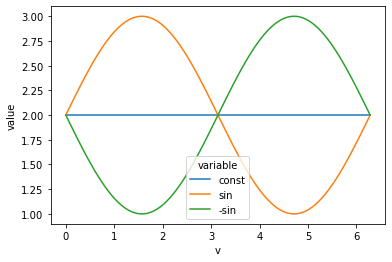

In [7]:
sns.lineplot(
    data=prices.melt(
        id_vars=['v'],
        value_vars=['const', 'sin', '-sin']),
    x='v',
    y='value',
    hue='variable')

No (non-timed) "buy and hold" strategy would make a lot of money on this situation, as all instruments have the same start and end price.

However, the universal portfolio can re-balance its way into some returns.

In [8]:
run_simulation(
    price_sequence=prices.loc[:, ['const', 'sin', '-sin']])

1.0164958357594527

In [9]:
# can do better if we forget earlier events at the right rate
run_simulation(
    price_sequence=prices.loc[:, ['const', 'sin', '-sin']],
    forgive_rate=0.1)

1.0551065769405392

The simulation returns the ending value, assuming the starting value was 1. So numbers above 1 are profit, and below are losses.

The Cover universal portfolio is "distribution free" (how we say uses very few assumptions). This means it may not be as fast as a strategy that had external hints that the system was oscillating.

We can try the universal portfolio on a harder example: random noise.

We expect the mean return to 1 (same money comes out as goes in) *and* low standard deviation (evidence we are not doing something horrible like the running the [small Martingale](https://en.wikipedia.org/wiki/Martingale_(betting_system)) in disguise).  The expected value zero is really just checking our simulation code- one of the oddities of finance is in the absence of trading costs it is just as hard to lose money to random noise as it is to make money from random noise.

In [10]:
# build Martingale or zero change in expectation pricing from
# fair coin flips
def prices_from_flips(coin_flips, *, delta: float = 0.1) -> List[float]:
    # set up symmetric simulated returns
    # notice we are making them expected value zero
    returns = [1.0 + delta, 1.0 - delta]
    cur_price = 1.0
    prices = [np.array([1.0, cur_price])]
    for flip in coin_flips:
        cur_price = cur_price * returns[flip]
        prices.append(np.array([1.0, cur_price]))
    prices = pd.DataFrame(prices)
    prices.columns = ['cosnt', 'random_walk']
    return prices

First we try the perfect distribution of trials, re-simulating the strategy for each possible 8 coin flip sequence occurring exactly once.

In [11]:
# try the portfolio on every possible 8 coin flip sequence
results_perfect = np.array([
    run_simulation(price_sequence=prices_from_flips(coin_flips))
    for coin_flips in product(range(2), repeat=8)
])

In [12]:
np.mean(results_perfect)

1.000000000000004

In [13]:
np.std(results_perfect)

0.14235012456684218

The observed standard deviation is not minuscule. This is because we are interested in  how far away the mean is from 1.0 (not from 0.0). The strategy is making substantial money in some sequences, and losing substantial money on others.

We can also try for a random population. These numbers should be close to the previous ones.

In [14]:
# https://numpy.org/doc/stable/reference/random/performance.html#recommendation
rand_gen = np.random.Generator(np.random.PCG64(seed=1996))  # numpy default
# rand_gen = np.random.Generator(np.random.Philox(seed=2022))

def gen_flips(n, *, delta: float = 0.1):
    return rand_gen.choice([0, 1], size=n, replace=True)


results_random = np.array([
    run_simulation(price_sequence=prices_from_flips(gen_flips(8)))
    for rep in range(100)
])


In [15]:
np.mean(results_random)

1.0061625564393726

In [16]:
np.std(results_random)

0.146753957449536

And that is Cover's universal portfolio idea translated into Python. I wouldn't use this implementation for speed, as it was coded for clarity. Also, do not take theoretical finance as directly actionable financial advice- we are commenting only on the math.
